Importing and Preprocessing Initial Data 

In [1]:
from Models import FileManagement
from Models import DataManagement
import pandas as pd
import numpy as np
import warnings
# suppress pandas warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

file_path :str = "data/iphi2802.csv"

data :pd.DataFrame = FileManagement.Import.data(file_path=file_path).from_csv()

# remove unnecessary columns
DataManagement.ClearData().from_columns(data, column_names=['metadata', 'id', 'region_main', 'region_sub', 'date_str', 'date_circa'])
# remove whitespace
DataManagement.ClearData().from_whitespace(data, column_names=['text'])
# make all characters uppercase
DataManagement.ClearData().from_uppercase_letters(data, column_names=['text'])
# remove non needing characters
DataManagement.ClearData().from_characters(data, r_characters=['\[', '\]', '-', '\.'], character='', column_names=["text"])
# remove single characters words
DataManagement.ClearData().from_single_characters(data, column_names=['text'])
print("Initial clear done")

stop_words = FileManagement.Import().data('./data/greek_stopwords.json').from_json('utf-8') # retrieve all stop words
DataManagement.ClearData().from_words(data['text'], stop_words) # remove stop words from data
print("Removed Stop Words")

# find all the words that we need to remove from the library and remove them
remaining_words = DataManagement.Visualization().get_dictionary(data['text'])
words_to_remove = [word for (word, freq) in remaining_words if freq < 5]

DataManagement.ClearData().from_words(data['text'], words_to_remove) # remove all other words we found text cells that appeared
print("Removed Remaining Words")
DataManagement.ClearData().from_empty_string_cells(data, 'text') # remove all empty string text cells that appeared
print("Removed Empty Text Cells")


Initial clear done
Removed Stop Words
Removed Remaining Words
Removed Empty Text Cells


Vectorize Text

In [2]:
# vectorize text words with tf_idf vectorizer
text_vectorized = DataManagement.Vectorizer().tf_idf(data["text"])
print("Text Vectorized")

# create the norm dataset
norm_dataset = np.hstack((text_vectorized, data[['region_main_id', 'region_sub_id', 'date_min', 'date_max']].to_numpy()))

Text Vectorized


Transform data

In [3]:
# X_y = [text_vectorized_0, ..., text_vectorized_n, region_main_id, region_sub_id, date_min, date_max]
X_y = DataManagement.Preprocess().MinMaxScaler(norm_dataset)

X, y = DataManagement.Preprocess().slice_from_end_2d_array(X_y, 2)
print("Data split into X and y")

Data split into X and y


# Create and Test Models

### One layer Models

In [8]:
from Models import PyTorch_NN

INPUT_NODES = np.shape(X)[1]
OUTPUT_NODES = 2

sequential_model = PyTorch_NN.PyTorchModel(hidden_layer_nodes=int((2 * INPUT_NODES) - (INPUT_NODES/8)), epochs=200, batch_size=16, X=X, y=y)
sequential_model.create_default_model()
sequential_model.print_model()

Sequential(
  (0): Linear(in_features=1899, out_features=3560, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3560, out_features=2, bias=True)
)
HIDDEN_LAYER_NODES=3560   OUT_NODES = 2   EPOCHS=200   BATCH_SIZE=16


Fold #1
Epoch 200/200, Validation Loss: 0.010947615839540958
Fold #2
Epoch 200/200, Validation Loss: 0.004867094568908215
Fold #3
Epoch 200/200, Validation Loss: 0.004133867099881172
Fold #4
Epoch 200/200, Validation Loss: 0.003083637682721019
Fold #5
Epoch 200/200, Validation Loss: 0.002223698887974024


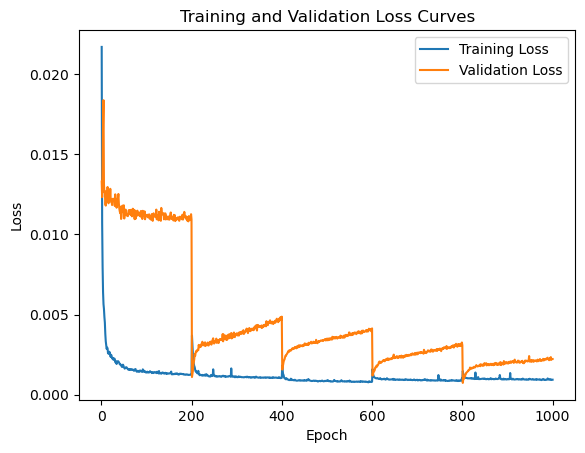

Fold score (RMSE): 0.047156114131212234


In [9]:
sequential_model.train_test(with_early_stopping=False, patience=50)

### Multilayer Model with Learning Rate and Momentum

In [24]:
from Models import PyTorch_NN
import torch.nn as nn
from collections import OrderedDict

INPUT_NODES = np.shape(X)[1]
OUTPUT_NODES = 2
HIDDEN_LAYER_NODES: int = int((2 * INPUT_NODES) - (INPUT_NODES/8))

multilayer_model = PyTorch_NN.PyTorchModel(
    hidden_layer_nodes=HIDDEN_LAYER_NODES,
    epochs=200,
    batch_size=16,
    X=X, y=y,
    momentum=0.2,
    learning_rate=0.001
)
multilayer_model.model = nn.Sequential(OrderedDict([
    ('dropout', nn.Dropout()),
    ('dense1', nn.Linear(np.shape(X)[1], HIDDEN_LAYER_NODES).cuda()),
    ('act1', nn.ReLU().cuda()),
    ('dense2', nn.Linear(HIDDEN_LAYER_NODES, int(HIDDEN_LAYER_NODES/2)).cuda()),
    ('act2', nn.ReLU().cuda()),
    ('output', nn.Linear(int(HIDDEN_LAYER_NODES/2), 2).cuda()),
    ('outAct', nn.Sigmoid().cuda()),
]))

multilayer_model.print_model()

Sequential(
  (dense1): Linear(in_features=1899, out_features=3560, bias=True)
  (act1): ReLU()
  (dense2): Linear(in_features=3560, out_features=1780, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=1780, out_features=2, bias=True)
  (outAct): Sigmoid()
)
HIDDEN_LAYER_NODES=3560   OUT_NODES = 2   EPOCHS=200   BATCH_SIZE=16


In [ ]:
multilayer_model.train_test(with_early_stopping=False)

### Model with Dropout

In [ ]:
from Models import PyTorch_NN
import torch.nn as nn
from collections import OrderedDict

INPUT_NODES = np.shape(X)[1]
OUTPUT_NODES = 2
HIDDEN_LAYER_NODES: int = int((2 * INPUT_NODES) - (INPUT_NODES/8))
R_IN = 0.5
R_H = 0.5
multilayer_dropout_model = PyTorch_NN.PyTorchModel(
    hidden_layer_nodes=HIDDEN_LAYER_NODES,
    epochs=200,
    batch_size=16,
    X=X, y=y,
    momentum=0.2,
    learning_rate=0.001,
    with_dropout=True,
    r_in=R_IN,
    r_h=R_H
)
multilayer_dropout_model.model = nn.Sequential(OrderedDict([
    ('dropoutIn', nn.Dropout(R_IN).cuda()),
    ('dense1', nn.Linear(np.shape(X)[1], HIDDEN_LAYER_NODES).cuda()),
    ('act1', nn.ReLU().cuda()),
    ('dropoutH1', nn.Dropout(R_H).cuda()),
    ('dense2', nn.Linear(HIDDEN_LAYER_NODES, int(HIDDEN_LAYER_NODES/2)).cuda()),
    ('act2', nn.ReLU().cuda()),
    ('dropoutH2', nn.Dropout(R_H).cuda()),
    ('output', nn.Linear(int(HIDDEN_LAYER_NODES/2), 2).cuda()),
    ('outAct', nn.Sigmoid().cuda()),
]))

multilayer_dropout_model.print_model()

In [ ]:
multilayer_dropout_model.train_test(with_early_stopping=False)